# Introduction

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. 

### Further Resources and References

Manual Exploration was taken from an Udacity Project:

https://github.com/torenunez/machine-learning/blob/master/projects/titanic_survival_exploration/titanic_survival_exploration.ipynb


Pre-processing and modeling was taken from the following Kaggle Kernel: 

https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster




# Setup

In [1]:
import re
import operator
import warnings

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot') 


/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("input/train.csv", dtype={"Age": np.float64})
test  = pd.read_csv("input/test.csv", dtype={"Age": np.float64})

# Manual Exploration

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code cell below to remove **Survived** as a feature of the dataset and store it in `outcomes`.

In [3]:
# Peak at the top of the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape)
train.describe()
train.count()

(891, 12)


PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [5]:
pd.crosstab(train['Survived'], train['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


In [6]:
sex_class = train.groupby(['Sex', 'Pclass'])
sex_class.mean()['Survived']

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

In [7]:
def age_hist(df):
    
    bins = np.arange(0, df['Age'].max() + 10, 10)

    key = 'Age'
    nonsurv_vals = df[df['Survived'] == 0][key].reset_index(drop = True).dropna()
    surv_vals = df[df['Survived'] == 1][key].reset_index(drop = True).dropna()

    plt.hist(nonsurv_vals, bins = bins, alpha = 0.5, color = 'red', label = 'Did not survive')
    plt.hist(surv_vals, bins = bins, alpha = 0.5, color = 'green', label = 'Survived')
    plt.xlim(0, bins.max())
    plt.legend(framealpha = 0.8)

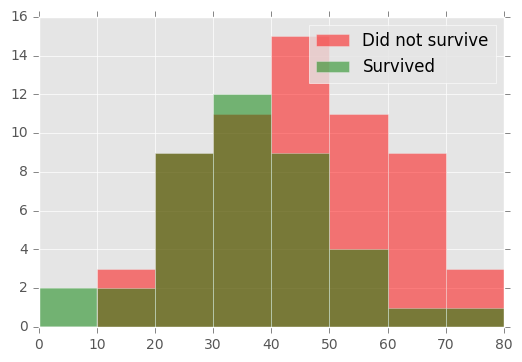

In [8]:
ma=train['Sex']=='male'
c1=train['Pclass']==1
ma_c1_df=train[ma&c1]
age_hist(ma_c1_df)

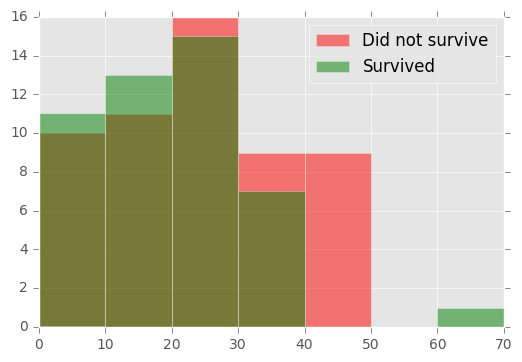

In [9]:
fem=train['Sex']=='female'
c3=train['Pclass']==3
fem_c3_df = train[fem&c3]
age_hist(fem_c3_df)

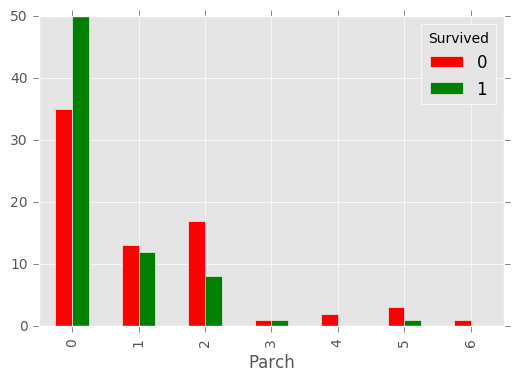

In [10]:
fem_c3_by_parch_df = pd.crosstab(fem_c3_df['Parch'], fem_c3_df['Survived'])
fem_c3_by_parch_df.plot.bar(color = ['r','g'])

In [11]:
def manual_tree(data):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    
    predictions = []
    for _, passenger in data.iterrows():
        
        if passenger['Sex']=='female':
            if passenger['Pclass'] ==3:
                if passenger['Age'] > 30 and passenger['Age'] < 60:
                    three = 0
                elif passenger['Parch'] > 1:
                    three = 0
                else:
                    three = 1
            else:
                three = 1
        else:
            if passenger['Age'] < 10:
                three = 1
            elif passenger['Age'] > 30 and passenger['Age'] < 40:
                if passenger['Pclass'] == 1:
                    three = 1
                else:
                    three = 0
            else:
                three = 0

        predictions.append(three)
    
    # Return our predictions
    return pd.Series(predictions)

In [12]:
y_pred1 = manual_tree(train)

y_train = train.Survived

accuracy_score(y_pred1, y_train)

0.81593714927048255

# Feature Engineering

In [13]:
target = train["Survived"].values
full = pd.concat([train, test])
#print(full.head())
#print(full.describe())
#print(full.info())

full['surname'] = full["Name"].apply(lambda x: x.split(',')[0].lower())

full["Title"] = full["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
full["TitleCat"] = full.loc[:,'Title'].map(title_mapping)

full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["FamilySize"] = pd.cut(full["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

full["NameLength"] = full["Name"].apply(lambda x: len(x))

full["Embarked"] = pd.Categorical.from_array(full.Embarked).codes

full["Fare"] = full["Fare"].fillna(8.05)

full = pd.concat([full,pd.get_dummies(full['Sex'])],axis=1)

full['CabinCat'] = pd.Categorical.from_array(full.Cabin.fillna('0').apply(lambda x: x[0])).codes

/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: Categorical.from_array is deprecated, use Categorical instead


In [14]:
# function to get oven/odd/null from cabine 
def get_type_cabine(cabine):
    # Use a regular expression to search for a title. 
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'

In [15]:
full["Cabin"] = full["Cabin"].fillna(" ")

full["CabinType"] = full["Cabin"].apply(get_type_cabine)
#print(pd.value_counts(full["CabinType"]))

In [16]:
#### CHILD/FEMALE ADULT/MALE ADULT------------------------------------------------------------
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'
full = pd.concat([full, pd.DataFrame(full[['Age', 'Sex']].apply(get_person, axis=1), columns=['person'])],axis=1)
full = pd.concat([full,pd.get_dummies(full['person'])],axis=1)

In [17]:
### FEATURES BASED ON TICKET   --------------------------------------------------------
table_ticket = pd.DataFrame(full["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)

table_ticket['Ticket_perishing_women'] = full.Ticket[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0 

table_ticket['Ticket_surviving_men'] = full.Ticket[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

table_ticket["Ticket_Id"]= pd.Categorical.from_array(table_ticket.index).codes
# compress under 3 members into one code.
table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)

/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [18]:
### FEATURES BASED ON SURNAME    --------------------------------------------------------
table_surname = pd.DataFrame(full["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = full.surname[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = full.surname[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical.from_array(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_surname, left_on="surname",right_index=True,how='left', sort=False)

/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [19]:
### AGE PROCESSING --------------------------------------------------------------------------
classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200)
X_train = full[classers][full['Age'].notnull()]
Y_train = full['Age'][full['Age'].notnull()]
X_test = full[classers][full['Age'].isnull()]
etr.fit(X_train,np.ravel(Y_train))
age_preds = etr.predict(X_test)
full['Age'][full['Age'].isnull()] = age_preds

/home/torenunez/anaconda3/envs/udacity-ml27/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# FEATURES -----------------------------------------------------------------------------------
features = ['female','male','Age','male_adult','female_adult', 'child','TitleCat', 'Pclass',
'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
'Fare','Embarked','Surname_Members','Ticket_Members','FamilySize',
'Ticket_perishing_women','Ticket_surviving_men',
'Surname_perishing_women','Surname_surviving_men']

train = full[0:891].copy()
test = full[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_perishing_women
13.04 Surname_surviving_men
10.36 Surname_perishing_women
6.94 Embarked
5.27 Ticket_Members
3.59 child
2.93 FamilySize
1.83 Parch
1.78 Age
1.07 Ticket_Id
0.73 Surname_Members
0.53 SibSp


# Training the Model

In [21]:
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})


# CROSS VALIDATION WITH RANDOM FOREST CLASSIFIER METHOD-----------------------------------------
kf = cross_validation.KFold(train.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(rfc, train[features], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features], target)
score = rfc.score(train[features], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))

Accuracy: 89.338 (+/- 0.97) [RFC Cross Validation]
Accuracy: 96.409            [RFC full test]
1. feature 3 (8.961399) Age
2. feature 16 (8.700295) Fare
3. feature 11 (8.466131) NameLength
4. feature 21 (7.156647) Ticket_perishing_women
5. feature 7 (6.961222) TitleCat
6. feature 23 (6.707909) Surname_perishing_women
7. feature 2 (6.675942) male
8. feature 1 (6.103385) female
9. feature 4 (5.190511) male_adult
10. feature 22 (4.478257) Ticket_surviving_men
11. feature 8 (4.071362) Pclass
12. feature 9 (3.975727) Pclass
13. feature 5 (3.532406) female_adult
14. feature 19 (2.633184) Ticket_Members
15. feature 24 (2.546482) Surname_surviving_men
16. feature 13 (2.404580) CabinCat
17. feature 20 (2.257098) FamilySize
18. feature 18 (1.851895) Surname_Members
19. feature 12 (1.804174) CabinType
20. feature 17 (1.712935) Embarked
21. feature 10 (1.255696) Ticket_Id
22. feature 14 (1.125660) SibSp
23. feature 15 (0.733932) Parch
24. feature 6 (0.693170) child


# Generate Prediction

In [22]:
# Accuracy: 89.450 (+/- 0.84) [RFC Cross Validation]
# Accuracy: 96.296            [RFC full test]

# PREDICTION  -----------------------------------------------------------------------------------
rfc.fit(train[features], target)
predictions = rfc.predict(test[features])

# OUTPUT FILE -----------------------------------------------------------------------------------
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])

#my_prediction.to_csv("titanic_prediction.csv", index_label = ["PassengerId"])